In [1]:
import tools
import plotting
import torch
import numpy as np

In [2]:
image_paths = ['sample_image/1000268201_693b08cb0e.jpg', 'sample_image/1001773457_577c3a7d70.jpg']
texts = [
    'child in a pink dress is climbing up a set of stairs in an entry way',
    'طفلة صغيرة تتسلق إلى مسرح خشبي',
    'A dog and a cat',
    'نساء في السودان',
]
english_captions = [texts[0], texts[2]]
arabic_captions = [texts[1], texts[3]]
all_captions = {'English': english_captions, 'Arabic': arabic_captions}

#set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
tokenizer = tools.load_tokenizer()
multi_clip_model = tools.load_multilingual_clip(device='cpu')
clip_model, preprocess = tools.load_clip(device=device)
input_images, org_images = tools.load_images(image_paths, preprocess, device=device)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
language_embs = {}
with torch.no_grad():
    image_embs = clip_model.encode_image(input_images).float().cpu()
    for lang, captions in all_captions.items():
      language_embs[lang] = multi_clip_model(captions, tokenizer).float().cpu()


In [5]:
print("CLIP-Vision: {}".format(image_embs.shape))
for lang, embs in language_embs.items():
  print("{}: {}".format(lang, embs.shape))

CLIP-Vision: torch.Size([2, 768])
English: torch.Size([2, 768])
Arabic: torch.Size([2, 768])


In [6]:
# CLIP Temperature scaler
logit_scale = clip_model.logit_scale.exp().float().to('cpu')

language_logits = {}
for lang, embs in language_embs.items():
  language_logits[lang] = tools.compare_embeddings(logit_scale, image_embs, embs)

Language: English


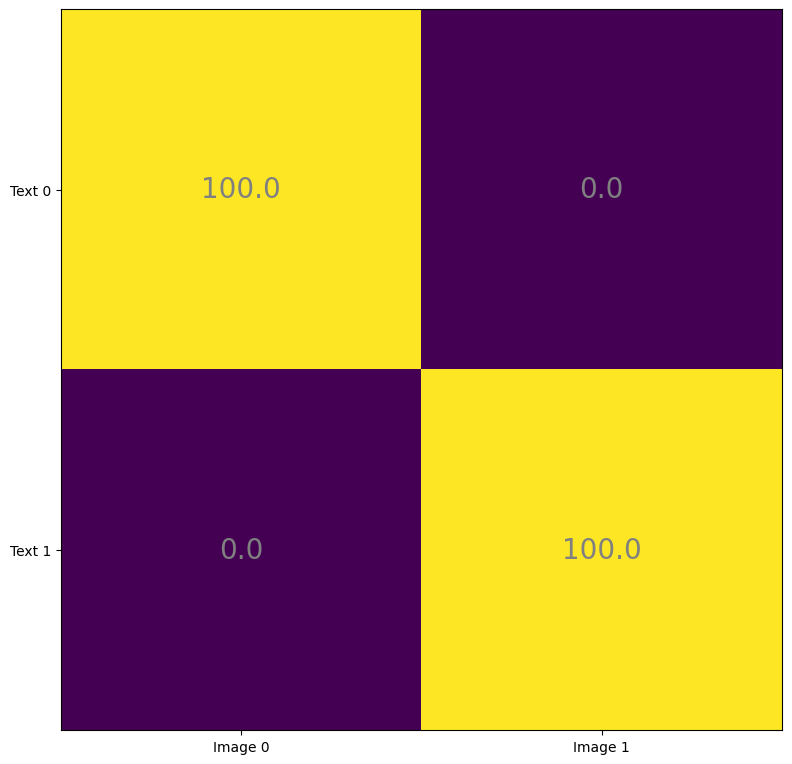

Language: Arabic


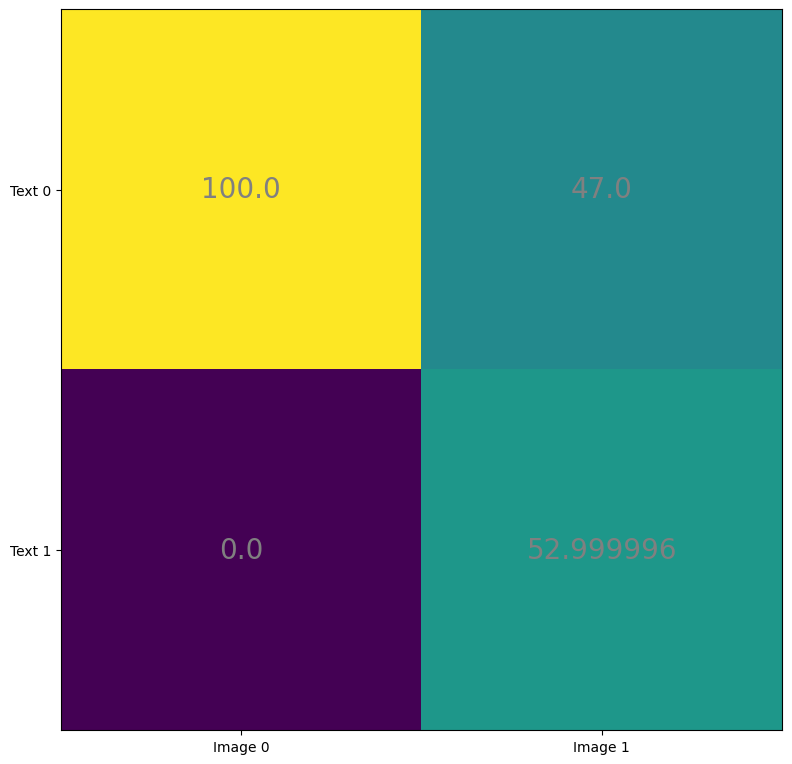

In [7]:
for lang, (img_logits, txt_logits) in language_logits.items():
  # Convert Logits into Softmax predictions
  probs = img_logits.softmax(dim=-1).cpu().detach().numpy()

  # Transpose so that each column is the softmax for each picture over the texts
  probs = np.around(probs, decimals=2).T * 100

  print("Language: {}".format(lang))
  plotting.plot_heatmap(probs)